An initial attempt at a study justifying the number of iterations used for Uni-/MultiFold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import livelossplot
import tensorflow as tf

### Custom functions
from omnifold import *
from omnifold.utilities import *

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0], 
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [3]:
### GPU Setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number between 0 & 3
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-09-23 11:33:41.767735: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-23 11:33:42.731929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2021-09-23 11:33:42.732590: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-23 11:33:42.734857: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-23 11:33:42.737070: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-09-23 11:33:42.737525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-0

In [4]:
plot_setup()
plt.rcParams.update({"font.family": "serif",})

In [5]:
plot_dir = './plots/'
save_label0 = 'iteration_test'

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [6]:
folder = '/clusterfs/ml4hep/adisurtya/ATLASOmniFold/slimmedSamples/'

In [7]:
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

In [8]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [9]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

True

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably: 

In [13]:
# [col for col in columns if col.endswith("_tracks")]

In [12]:
# f_mc['OmniTree'].arrays(
#     ["weight","pT_tracks"],
#     library="pd")

Let's ignore the MultiIndex variables for now.

In [14]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

MC has 416,725 events with 57 columns.
Data has 3,578,623 events with 57 columns.


### Apply event selection

In [15]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

In [37]:
# this "or" selection doesn't do anything...
mc_truth_weights = mc[(mc.pass190 | mc.truth_pass190)].weight_mc
mc_reco_weights = mc[(mc.pass190 | mc.truth_pass190)].weight

data_truth_weights = data[data.truth_pass190].weight_mc
data_reco_weights = data[data.pass190].weight

In [38]:
mc.truth_pass190.value_counts()

True     394620
False     22105
Name: truth_pass190, dtype: int64

In [39]:
mc.pass190.value_counts()

True     344533
False     72192
Name: pass190, dtype: int64

In [40]:
np.sum(np.array(mc[(mc.pass190 | mc.truth_pass190)].weight_mc) == np.array(mc.weight_mc))

416725

In [41]:
len(mc[(mc.pass190 == False) & (mc.truth_pass190 == False)])

0

Normalize the weights:

In [43]:
for weights in [mc_truth_weights, mc_reco_weights, data_truth_weights, data_reco_weights]:
    weights /= np.mean(weights)

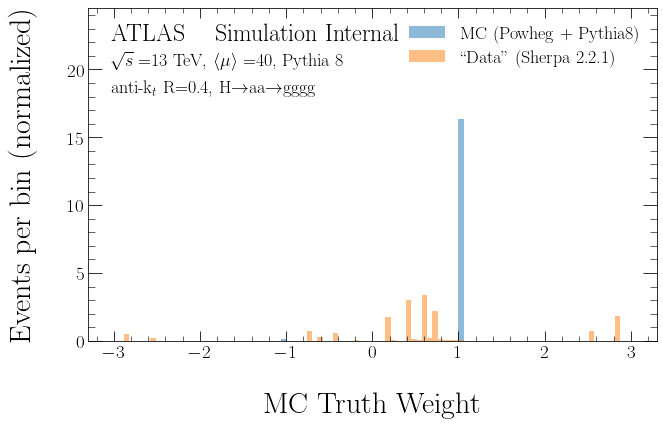

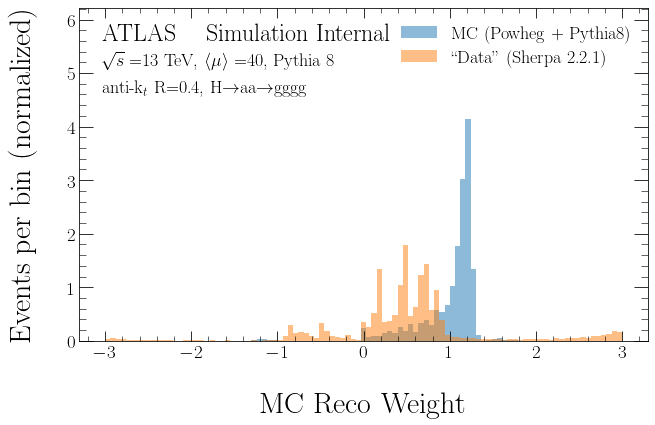

In [44]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(mc_truth_weights,
                              bins=bins,
                              label=r'MC (Powheg + Pythia8)',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth_weights,
                               bins=bins,
                               label=r'``Data" (Sherpa 2.2.1)',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(mc_reco_weights,
                             bins=bins,
                             label=r'MC (Powheg + Pythia8)',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data_reco_weights,
                              bins=bins,
                              label=r'``Data" (Sherpa 2.2.1)',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()

### Load IBU histograms for comparison

In [45]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [46]:
IBU_hists = uproot.open('/clusterfs/ml4hep/adisurtya/ATLASOmniFold/unfoldingPlotsJune14_UnfoldedHists.root')

bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]

In [47]:
labels_and_bins = zip(file_labels, plot_labels, bins)

ibu_hists = []

for file_label, plot_label, plot_bins in labels_and_bins:
    ibu_hists += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

In [48]:
ibu_hists_df = pd.DataFrame(ibu_hists)

In [49]:
ibu_hists_df

,file_label,plot_label,bins
0,Ntracks_trackj1,Leading track jet $n_{\textrm{ch}}$,"[1.0, 5.0, 7.0, 10.0, 13.0, 16.0, 20.0, 30.0, ..."
1,Ntracks_trackj2,Subleading track jet $n_{\textrm{ch}}$,"[1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 11.0, 15.0, 20...."
2,m_trackj1,Leading track jet $m$ [GeV],"[0.0, 10.0, 20.0, 30.0, 40.0, 80.0]"
3,m_trackj2,Subleading track jet $m$ [GeV],"[0.0, 2.5, 5.0, 10.0, 20.0, 70.0]"
4,pT_trackj1,Leading track jet $p_T$ [GeV],"[0.0, 50.0, 100.0, 150.0, 200.0, 300.0, 1000.0]"
5,pT_trackj2,Subleading track jet $p_T$ [GeV],"[0.0, 25.0, 50.0, 100.0, 700.0]"
6,y_trackj1,Leading track jet $y$,"[-2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, ..."
7,y_trackj2,Subleading track jet $y$,"[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, ..."
8,phi_trackj1,Leading track jet $\phi$,"[-3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1...."
9,phi_trackj2,Subleading track jet $\phi$,"[-3.2, -2.8, -2.4, -2.0, -1.6, -1.2, -0.8, -0...."


### Unifold

In [50]:
K.clear_session()

In [51]:
unifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_truth_weights)))

In [52]:
unifold_weights.shape # (n_variables, n_events)

(24, 416725)

In [53]:
i = 0 # index of variable of interest (num_tracks for leading jet)
bins = ibu_hists[i]['bins']
x_label = ibu_hists[i]['plot_label']
file_label = ibu_hists[i]['file_label']
save_label = plot_dir+'UniFold/'+file_label+'/'+save_label0+'-UniFold-'+file_label

Grab the particular variable you care about, and set a dummy value for events that don't pass each MC selection:

In [55]:
dummyval = -99
mc_truth = mc[(mc.pass190 | mc.truth_pass190)]['truth_' + file_label]
mc_truth[mc.truth_pass190 == False] = dummyval
mc_reco = mc[(mc.pass190 | mc.truth_pass190)][file_label]
mc_reco[mc.pass190 == False] = dummyval

data_truth = data[data['truth_pass190']]['truth_' + file_label]
data_reco = data[data['pass190']][file_label]

Plot this observable in MC & "data" before unfolding:

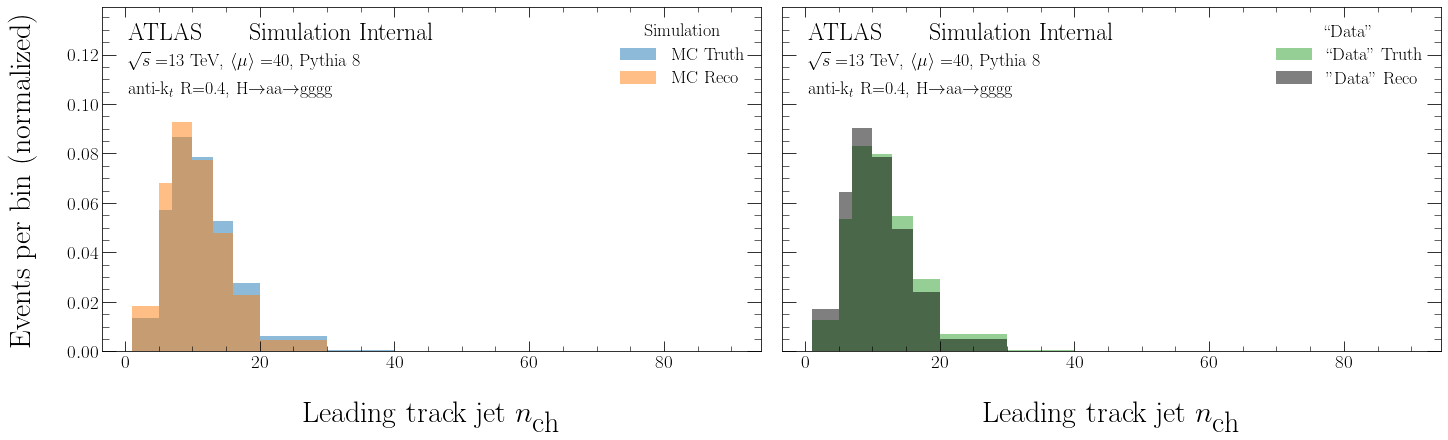

In [56]:
plot_distributions(
    sim_truth=mc_truth,
    sim_reco=mc_reco,
    sim_truth_weights_MC=mc_truth_weights,
    sim_reco_weights_MC=mc_reco_weights,
    data_truth=data_truth,
    data_reco=data_reco,
    data_truth_weights_MC=data_truth_weights,
    data_reco_weights_MC=data_reco_weights,
    bins=bins,
    x_label=x_label,
    save_label=save_label
)

Standardize the data by z-score:

In [57]:
# z-score standardization of data

mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc_truth), 
                                                   np.array(mc_reco),
                                                   np.array(data_reco))

In [58]:
weights, _ = unifold(iterations=3,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc_truth_weights,
                     sim_reco_weights_MC=mc_reco_weights,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights,
                     dummyval=dummyval,
                     verbose=1)

2021-09-23 11:42:17.130958: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-09-23 11:42:17.140265: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994305000 Hz
2021-09-23 11:42:17.142319: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559b84ef82f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-23 11:42:17.142363: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-23 11:42:17.222880: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559b88ab2ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-09-23 11:42:17.222929: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2021-09-23 11:42:17.225025: I tenso


ITERATION: 1

STEP 1

Epoch 1/1000


2021-09-23 11:47:28.504188: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


245/245 [==============================] - 1s 3ms/step - loss: 0.3742 - accuracy: 0.4458 - val_loss: 0.3362 - val_accuracy: 0.4473
Epoch 2/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3361 - val_accuracy: 0.4473
Epoch 3/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3361 - val_accuracy: 0.4473
Epoch 4/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3361 - val_accuracy: 0.4473
Epoch 5/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3360 - val_accuracy: 0.4473
Epoch 6/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3360 - val_accuracy: 0.4473
Epoch 7/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3362 - val_accuracy: 0.4473
Epoch

/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/unifold.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)



STEP 1b

Epoch 1/1000
49/49 [==============================] - 0s 5ms/step - loss: 1.5931 - accuracy: 0.2501 - val_loss: 1.5940 - val_accuracy: 0.2498
Epoch 2/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5930 - accuracy: 0.2501 - val_loss: 1.5940 - val_accuracy: 0.2498
Epoch 3/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5932 - accuracy: 0.2501 - val_loss: 1.5941 - val_accuracy: 0.2498
Epoch 4/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5930 - accuracy: 0.2501 - val_loss: 1.5943 - val_accuracy: 0.2498
Epoch 5/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5930 - accuracy: 0.2501 - val_loss: 1.5949 - val_accuracy: 0.2498
Epoch 6/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5929 - accuracy: 0.2501 - val_loss: 1.5950 - val_accuracy: 0.2498
Epoch 7/1000
49/49 [==============================] - 0s 4ms/step - loss: 1.5930 - accuracy: 0.2501 - val_loss: 1.5942 - val_accuracy: 0.2

In [71]:
unifold_weights[i] = best_1D_reweighting(
    test=mc_reco,
    test_weights=np.array(mc_reco_weights) * weights[:,1],
    target=data_reco,
    target_weights=data_reco_weights,
    bins=bins)

(array([3.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 1.20000e+01, 1.10000e+01, 2.30000e+01,
        1.47000e+02, 8.59000e+02, 1.24500e+03, 6.30000e+02, 3.23000e+02,
        2.24000e+02, 1.80000e+02, 1.41000e+02, 1.16000e+02, 8.70000e+01,
        7.50000e+01, 3.90000e+01, 5.67900e+03, 3.98000e+03, 5.58100e+03,
        8.15300e+03, 8.95200e+03, 1.07810e+04, 1.32700e+04, 1.69090e+04,
        2.22300e+04, 3.69060e+04, 8.64850e+04, 1.17929e+05, 6.19340e+04,
        9.49200e+03, 1.48800e+03, 1.38000e+03, 4.62000e+02, 3.27000e+02,
        1.12000e+02, 7.10000e+01, 7.30000e+01, 1.18000e+02, 1.11000e+02,
        5.60000e+01, 9.20000e+01, 1.80000e+01, 1.20000e+01, 6.00000e+00]),
 array([-2.53215888, -2.42127701, -2.31039513, -2.19951325, -2.08863138,
        -1.9777495 , -1.86686762, -1.75598575, -1.64510387, -1.53422199,
        -1.42334012, -1.31245824, -1.20157636, -1.09069449, -0.97981261,
        -0.86893073, -0.75804885, -0.64716698, -0

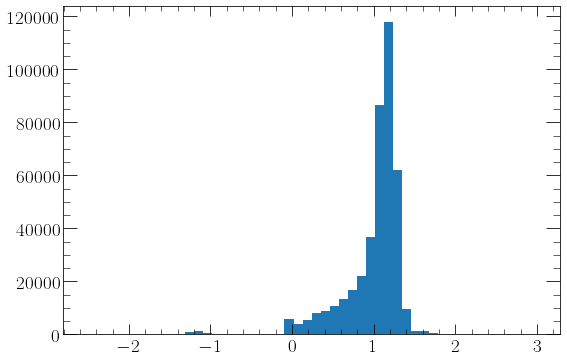

In [77]:
plt.hist(unifold_weights[i], bins=50)

ITERATION 1:
ITERATION 2:
ITERATION 3:


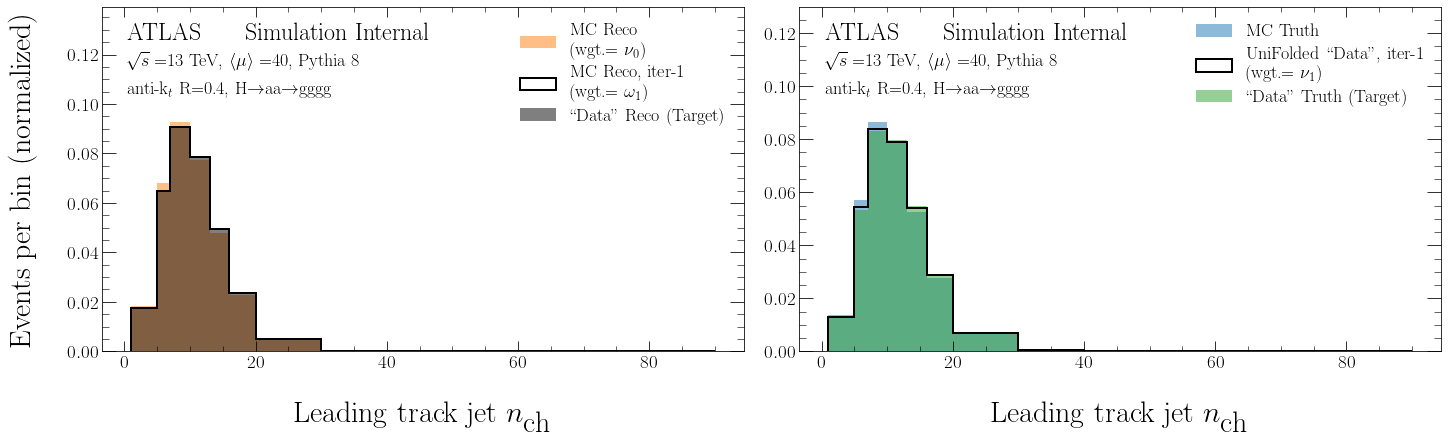

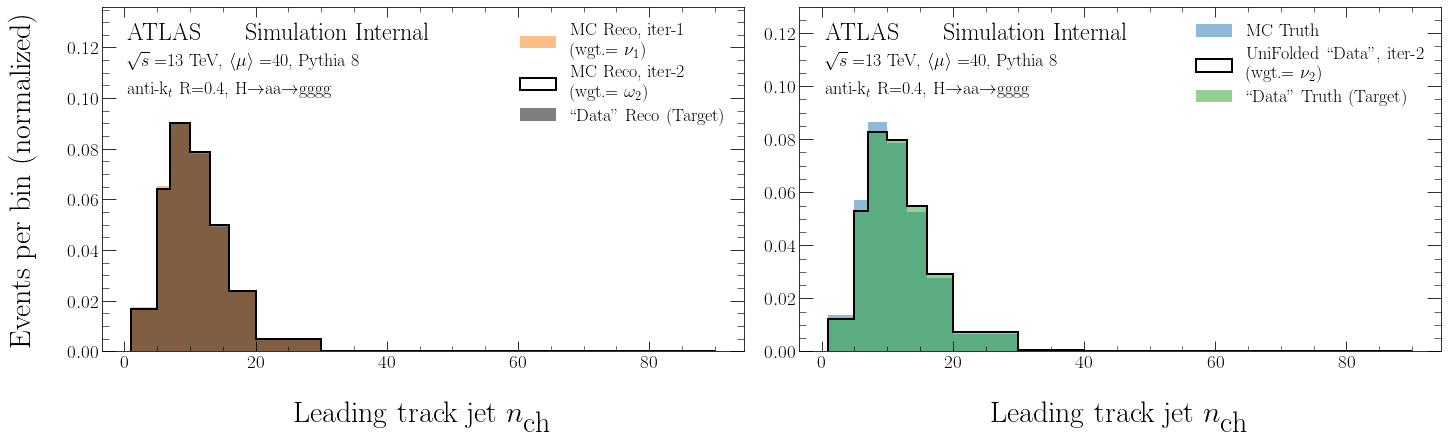

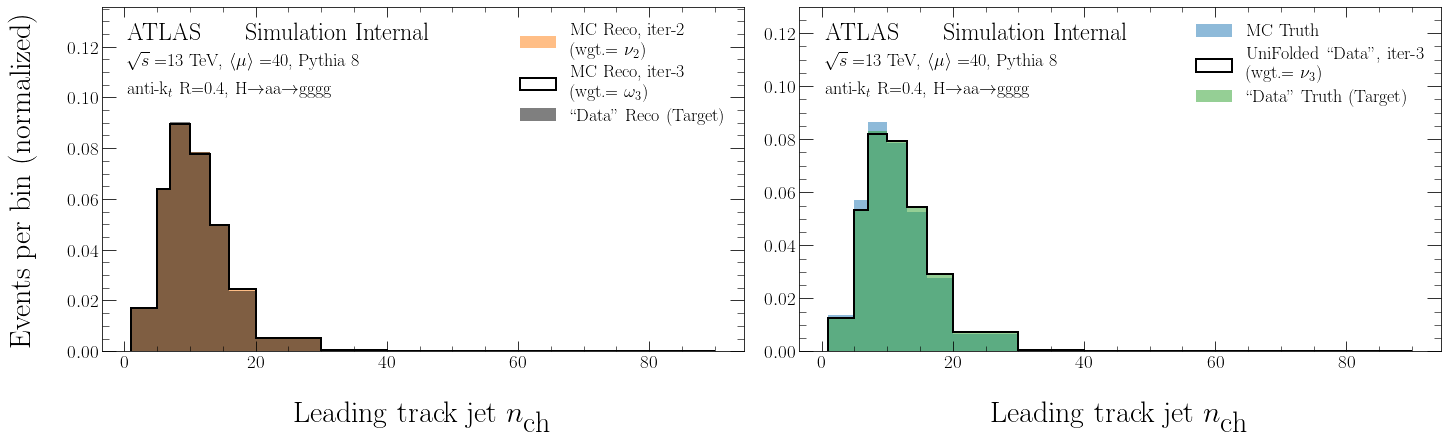

In [78]:
plot_results(sim_truth=mc_truth,
             sim_reco=mc_reco,
             sim_truth_weights_MC=mc_truth_weights,
             sim_reco_weights_MC=mc_reco_weights,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights,
             data_reco_weights_MC=data_reco_weights,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label
            )